# Load data from csv files

In [1]:
import pandas as pd

In [2]:
# Merge three csv files according to the column of 'system:index'
# 1. Merge "temperature" and "leaf_area" into temp_leaf by inner_join
# 2. Merge "burn_area" and temp_leaf into burned_temp_leaf by right_join
# If a csv file doesn't have matched 'system:index' value, the field value is 'nan'
# Reference link: https://datacarpentry.org/python-ecology-lesson/05-merging-data/index.html
samples = pd.read_excel('binary_classify_data.xlsx')

In [150]:
samples_copy = samples.copy()
# Fill in 100 for the uncertainty of date has no fire
y = samples_copy['Uncertainty'].fillna(0).values.tolist()
fire_max_index = y.index(0)
print(fire_max_index)
y_fire = y[:fire_max_index]
y_no_fire = y[fire_max_index:]
#print(y[:fire_max_index]
print(samples_copy.columns)

# Prune the unuseful columns
del samples_copy['system:index']
del samples_copy['Uncertainty']

#del samples_copy['elevation']
#del samples_copy['fnf']
del samples_copy['gHM'] # Not good

#del samples_copy['Fpar'] # Good for fire samples
del samples_copy['FparExtra_QC'] # A little good for fire samples but bad for no fire ones
#del samples_copy['FparLai_QC'] # Balance - fire samples(+), no fire samples(-)
del samples_copy['FparStdDev'] # Bad for fire samples
#del samples_copy['Lai']
#del samples_copy['LaiStdDev'] # Good for both

#del samples_copy['b1'] # Increase fire samples a lot and no fire ones a little

del samples_copy['ppt']   # No contribution
del samples_copy['tdmean'] # Balance - fire samples(+), no fire samples(-)
del samples_copy['tmax']  # No contribution
del samples_copy['tmean']  # No contribution
del samples_copy['tmin']   # Bad for fire smaples

del samples_copy['vpdmax'] # No contribution
#del samples_copy['vpdmin'] # Good for fire samples


X = samples_copy.values.tolist()
#print(X)
X_fire = X[:fire_max_index]
X_no_fire = X[fire_max_index:]

1063
Index(['system:index', 'Uncertainty', 'elevation', 'fnf', 'gHM', 'Fpar',
       'FparExtra_QC', 'FparLai_QC', 'FparStdDev', 'Lai', 'LaiStdDev', 'b1',
       'ppt', 'tdmean', 'tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin'],
      dtype='object')


In [184]:
from sklearn.model_selection import train_test_split
X_fire_train, X_fire_test, y_fire_train, y_fire_test = train_test_split(X_fire, y_fire, test_size=0.20, random_state=42)
X_no_fire_train, X_no_fire_test, y_no_fire_train, y_no_fire_test = train_test_split(X_no_fire, y_no_fire, test_size=0.25, random_state=42)
X_no_fire_train = X_no_fire_train[:len(y_fire_train)]
y_no_fire_train = y_no_fire_train[:len(y_fire_train)]
print(len(y_fire_train))

850


# Regression

In [186]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=5000)
X2_train = X_fire_train + X_no_fire_train
y2_train = y_fire_train + y_no_fire_train
#print(len(y2_train))
lr = lr.fit(X2_train, y2_train)

1700


In [179]:
import numpy as np
y_fire_pred = lr.predict(X_fire_test)
#print(y_fire_pred)
print(np.mean(y_fire_pred == y_fire_test))

y_no_fire_pred = lr.predict(X_no_fire_test)
print(np.mean(y_no_fire_pred == y_no_fire_test))
#print(y_fire_pred)
#print(y_no_fire_test)
#print(y_no_fire_pred)
#print(np.mean((y_no_fire_pred + y_fire_pred) == (y_no_fire_test + y_fire_pred)))

0.7652582159624414
0.687729937335759


In [183]:
#print(y_fire_pred)
#print(y_fire_test)
print(len(y_no_fire_pred))

24735


<class 'numpy.ndarray'>


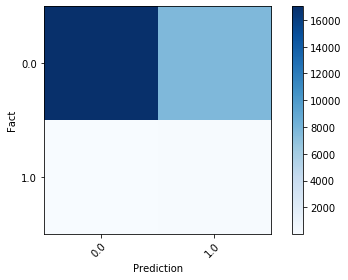

In [191]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

yy_test = y_fire_test + y_no_fire_test
#rint(yy_test)
print(type(y_fire_pred))
yy_pred = np.append(y_fire_pred, y_no_fire_pred)
cm = confusion_matrix(yy_test, yy_pred)

# Only uses the labels that appear in the data
labels = unique_labels(yy_test, yy_pred)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()